<a href="https://colab.research.google.com/github/anastasiiansm/AppliedMethodsinDE/blob/main/essentia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install build-essential libeigen3-dev libyaml-dev libfftw3-dev libavcodec-dev libavformat-dev libavutil-dev libswresample-dev libsamplerate0-dev libtag1-dev libchromaprint-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libavcodec-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavcodec-dev set to manually installed.
libavformat-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavformat-dev set to manually installed.
libavutil-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libavutil-dev set to manually installed.
libswresample-dev is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
libswresample-dev set to manually installed.
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
  libtag1v5 libtag1v5-vanilla
Suggested packages:
  libeigen3-doc libmpfrc++-dev libfftw3-doc libyaml-doc
The following NEW packages will be installed:
  libchromaprint-dev libeigen3-dev libfftw3-bin libfftw3-dev libfftw3-double3
  libfftw3-lon

In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

!sudo apt-get install python3-dev python3-numpy-dev python3-numpy python3-yaml python3-six

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'python3-numpy' instead of 'python3-numpy-dev'
python3-six is already the newest version (1.16.0-3ubuntu1).
python3-six set to manually installed.
python3-dev is already the newest version (3.10.6-1~22.04).
python3-dev set to manually installed.
Suggested packages:
  python-numpy-doc python3-pytest
The following NEW packages will be installed:
  python3-numpy python3-yaml
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 3,597 kB of archives.
After this operation, 19.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 python3-yaml amd64 5.4.1-1ubuntu1 [129 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Fetched 3,597 kB in 1s (3,217 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is i

In [ ]:
!pip install essentia-tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.4/291.4 MB 1.7 MB/s eta 0:00:00


In [ ]:
# prompt: convert a mp3 file to a wav file with the sampleRate of 16000, then play the wav file

!pip install pydub
from pydub import AudioSegment

# Replace 'input.mp3' with the actual path to your MP3 file
sound = AudioSegment.from_mp3("/content/Flowers by Miley Cyrus.mp3")
sound = sound.set_frame_rate(16000)

# Replace 'output.wav' with the desired name for your WAV file
sound.export("output.wav", format="wav")

from IPython.display import Audio
Audio("output.wav")


FileNotFoundError: [Errno 2] No such file or directory: '/content/Flowers by Miley Cyrus.mp3'

In [ ]:
#MSD-MusiCNN
#A Music embedding extractor based on auto-tagging with the 50 most common tags of the Million Song Dataset.

from essentia.standard import MonoLoader, TensorflowPredictMusiCNN, TensorflowPredict2D

audio = MonoLoader(filename="output.wav", sampleRate=16000, resampleQuality=4)()
embedding_model = TensorflowPredictMusiCNN(graphFilename="msd-musicnn-1.pb", output="model/dense/BiasAdd")
embeddings = embedding_model(audio)

#Music arousal and valence regression with the DEAM dataset (2 dimensions, range [1, 9]):

model = TensorflowPredict2D(graphFilename="deam-msd-musicnn-2.pb", output="model/Identity")
predictions = model(embeddings)

In [ ]:
# prompt: based on values of prediction, ouptut 0 if the majority of the first element of the numpy array is larger than 0.5 or 1 if the majority of the second element of the numpy array is larger than 0.5, write a function with predictions as the parameter

def classify_music(predictions):
  first_element_count = 0
  second_element_count = 0
  for prediction in predictions:
    if prediction[0] > 0.5:
      first_element_count += 1
    if prediction[1] > 0.5:
      second_element_count += 1
  if first_element_count > second_element_count:
    return 0
  else:
    return 1


#Approachability
Music approachability predicts whether the music is likely to be accessible to the general public (e.g., belonging to common mainstream music genres vs. niche and experimental genres).

In [ ]:
from essentia.standard import TensorflowPredictEffnetDiscogs

audio = MonoLoader(filename="output.wav", sampleRate=16000, resampleQuality=4)()
embedding_model = TensorflowPredictEffnetDiscogs(graphFilename="discogs-effnet-bs64-1.pb", output="PartitionedCall:1")
embeddings = embedding_model(audio)

model = TensorflowPredict2D(graphFilename="approachability_2c-discogs-effnet-1.pb", output="model/Softmax")
predictions = model(embeddings)
print(classify_music(predictions))

model = TensorflowPredict2D(graphFilename="approachability_regression-discogs-effnet-1.pb", output="model/Identity")
predictions = model(embeddings)
print(predictions.flatten().mean())


1
0.8770869


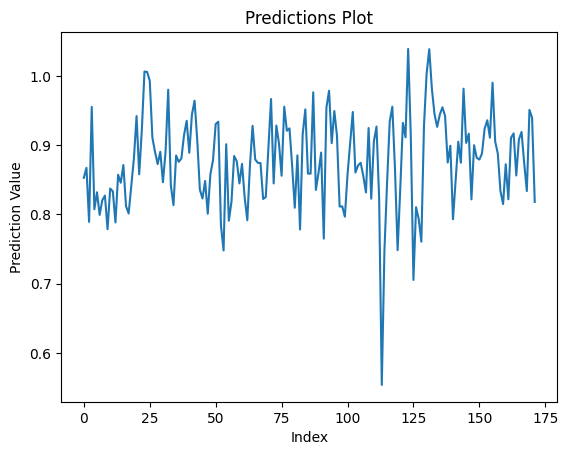

In [ ]:
# prompt: based on the value of predictions, make a plot of the each value according to the shape

import matplotlib.pyplot as plt

# Assuming 'predictions' is a NumPy array
plt.plot(predictions.flatten())  # Flatten the array if it's multi-dimensional
plt.xlabel("Index")
plt.ylabel("Prediction Value")
plt.title("Predictions Plot")
plt.show()


# Engagement

Music engagement predicts whether the music evokes active attention of the listener (high-engagement “lean forward” active listening vs. low-engagement “lean back” background listening).

In [ ]:
audio = MonoLoader(filename="output.wav", sampleRate=16000, resampleQuality=4)()
embedding_model = TensorflowPredictEffnetDiscogs(graphFilename="discogs-effnet-bs64-1.pb", output="PartitionedCall:1")
embeddings = embedding_model(audio)

model = TensorflowPredict2D(graphFilename="engagement_2c-discogs-effnet-1.pb", output="model/Softmax")
predictions = model(embeddings)
print(classify_music(predictions))

model = TensorflowPredict2D(graphFilename="engagement_regression-discogs-effnet-1.pb", output="model/Identity")
predictions = model(embeddings)
print(predictions.flatten().mean())

1
0.8966237


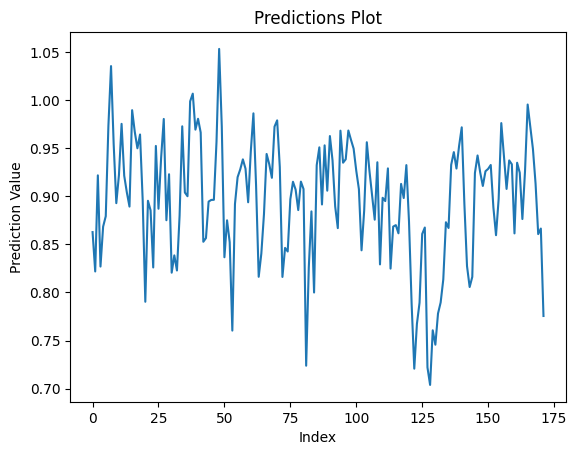

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'predictions' is a NumPy array
plt.plot(predictions.flatten())  # Flatten the array if it's multi-dimensional
plt.xlabel("Index")
plt.ylabel("Prediction Value")
plt.title("Predictions Plot")
plt.show()

# Danceability

Music danceability (2 classes):

danceable, not_danceable

In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D

audio = MonoLoader(filename="output.wav", sampleRate=16000, resampleQuality=4)()
embedding_model = TensorflowPredictEffnetDiscogs(graphFilename="discogs-effnet-bs64-1.pb", output="PartitionedCall:1")
embeddings = embedding_model(audio)

model = TensorflowPredict2D(graphFilename="danceability-discogs-effnet-1.pb", output="model/Softmax")
predictions = model(embeddings)
print(classify_music(predictions))

0


In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D
dance_p = "/content/drive/MyDrive/Ai-Generated Music Storage/danceability-discogs-effnet-1.pb"
dance_store=[]
for filename in os.listdir(input_folder):
  filepath = os.path.join(input_folder,filename)
  audio = MonoLoader(filename = filepath, sampleRate=16000, resampleQuality=4)()
  embedding_model = TensorflowPredictEffnetDiscogs(graphFilename=md1r, output="PartitionedCall:1")
  embeddings = embedding_model(audio)

  model = TensorflowPredict2D(graphFilename=dance_p, output="model/Softmax")
  predictions = model(embeddings)
  print(classify_music(predictions))
  dance_store.append(predictions)
print(dance_store)

# Mood Aggressive
Music classification by mood (2 classes):

aggressive, non_aggressive

In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D

audio = MonoLoader(filename="output.wav", sampleRate=16000, resampleQuality=4)()
embedding_model = TensorflowPredictEffnetDiscogs(graphFilename="discogs-effnet-bs64-1.pb", output="PartitionedCall:1")
embeddings = embedding_model(audio)

model = TensorflowPredict2D(graphFilename="mood_aggressive-discogs-effnet-1.pb", output="model/Softmax")
predictions = model(embeddings)
print(classify_music(predictions))

1


# Mood Happy
Music classification by mood (2 classes):

happy, non_happy

In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D

audio = MonoLoader(filename="output.wav", sampleRate=16000, resampleQuality=4)()
embedding_model = TensorflowPredictEffnetDiscogs(graphFilename="discogs-effnet-bs64-1.pb", output="PartitionedCall:1")
embeddings = embedding_model(audio)

model = TensorflowPredict2D(graphFilename="mood_happy-discogs-effnet-1.pb", output="model/Softmax")
predictions = model(embeddings)
print(classify_music(predictions))

0


# MagnaTagATune
Music automatic tagging with the top-50 tags of the MagnaTagATune dataset:

ambient, beat, beats, cello, choir, choral, classic, classical, country, dance, drums, electronic, fast, female, female
vocal, female voice, flute, guitar, harp, harpsichord, indian, loud, male, male vocal, male voice, man, metal, new age, no
vocal, no vocals, no voice, opera, piano, pop, quiet, rock, singing, sitar, slow, soft, solo, strings, synth, techno,
violin, vocal, vocals, voice, weird, woman


In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D

audio = MonoLoader(filename="output.wav", sampleRate=16000, resampleQuality=4)()
embedding_model = TensorflowPredictEffnetDiscogs(graphFilename="discogs-effnet-bs64-1.pb", output="PartitionedCall:1")
embeddings = embedding_model(audio)

model = TensorflowPredict2D(graphFilename="mtt-discogs-effnet-1.pb")
predictions = model(embeddings)

In [ ]:
predictions

array([[0.00931844, 0.07129219, 0.0152691 , ..., 0.01637203, 0.00804007,
        0.05396947],
       [0.00519586, 0.06387746, 0.0130631 , ..., 0.02628562, 0.00668037,
        0.0677475 ],
       [0.00503999, 0.06060648, 0.01175356, ..., 0.0197809 , 0.00402388,
        0.09609166],
       ...,
       [0.00433272, 0.05767998, 0.00409654, ..., 0.02515528, 0.00144634,
        0.10731909],
       [0.00404572, 0.05862778, 0.00768259, ..., 0.02871063, 0.0015848 ,
        0.19103333],
       [0.0141376 , 0.04036045, 0.00976393, ..., 0.06317776, 0.00979495,
        0.3072083 ]], dtype=float32)

In [ ]:
# prompt: given a list of 50 tags, predictions has the shape of [seconds, 50], output the top 5 tags when the value for each second is the highest and count the number of tags

import numpy as np

def top_5_tags(predictions, tag_list):
  """
  Given a list of 50 tags and predictions with shape [seconds, 50],
  output the top 5 tags when the value for each second is the highest
  and count the number of tags.

  Args:
    predictions: A NumPy array of shape [seconds, 50] containing predictions.
    tag_list: A list of 50 tags.

  Returns:
    A tuple containing:
      - A list of the top 5 tags.
      - A dictionary mapping tags to their counts.
  """

  # Find the index of the tag with the highest value for each second
  top_indices = np.argmax(predictions, axis=1)

  # Count the occurrences of each tag
  tag_counts = {}
  for idx in top_indices:
    tag = tag_list[idx]
    if tag not in tag_counts:
      tag_counts[tag] = 0
    tag_counts[tag] += 1

  # Sort the tags by count in descending order and get the top 5
  top_5_tags = sorted(tag_counts, key=tag_counts.get, reverse=True)[:5]

  return top_5_tags, tag_counts

# Example usage:
# Assuming 'predictions' is your NumPy array and 'tag_list' is your list of tags
tag_list = ["ambient", "beat", "beats", "cello", "choir", "choral", "classic", "classical", "country", "dance", "drums", "electronic", "fast", "female", "female vocal", "female voice", "flute", "guitar", "harp", "harpsichord", "indian", "loud", "male", "male vocal", "male voice", "man", "metal", "new age", "no vocal", "no vocals", "no voice", "opera", "piano", "pop", "quiet", "rock", "singing", "sitar", "slow", "soft", "solo", "strings", "synth", "techno", "violin", "vocal", "vocals", "voice", "weird", "woman"]
top_5, tag_counts = top_5_tags(predictions, tag_list)

print("Top 5 tags:", top_5)
print("Tag counts:", tag_counts)


Top 5 tags: ['female', 'pop', 'techno', 'electronic', 'guitar']
Tag counts: {'guitar': 1, 'pop': 66, 'female': 73, 'techno': 29, 'electronic': 2, 'woman': 1}


#MTG-Jamendo top50tags
Music automatic tagging using the top-50 tags of the MTG-Jamendo Dataset:

alternative, ambient, atmospheric, chillout, classical, dance, downtempo, easylistening, electronic, experimental, folk,
funk, hiphop, house, indie, instrumentalpop, jazz, lounge, metal, newage, orchestral, pop, popfolk, poprock, reggae, rock,
soundtrack, techno, trance, triphop, world, acousticguitar, bass, computer, drummachine, drums, electricguitar,
electricpiano, guitar, keyboard, piano, strings, synthesizer, violin, voice, emotional, energetic, film, happy, relaxing

In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D

audio = MonoLoader(filename="output.wav", sampleRate=16000, resampleQuality=4)()
embedding_model = TensorflowPredictEffnetDiscogs(graphFilename="discogs-effnet-bs64-1.pb", output="PartitionedCall:1")
embeddings = embedding_model(audio)

model = TensorflowPredict2D(graphFilename="mtg_jamendo_top50tags-discogs-effnet-1.pb")
predictions = model(embeddings)


tag_list = ["alternative", "ambient", "atmospheric", "chillout", "classical", "dance", "downtempo", "easylistening", "electronic", "experimental", "folk",
"funk", "hiphop", "house", "indie", "instrumentalpop", "jazz", "lounge", "metal", "newage", "orchestral", "pop", "popfolk", "poprock", "reggae", "rock",
"soundtrack", "techno", "trance", "triphop", "world", "acousticguitar", "bass", "computer", "drummachine", "drums", "electricguitar",
"electricpiano", "guitar", "keyboard", "piano", "strings", "synthesizer", "violin", "voice", "emotional", "energetic", "film", "happy", "relaxing"]

top_5, tag_counts = top_5_tags(predictions, tag_list)

print("Top 5 tags:", top_5)
print("Tag counts:", tag_counts)


Top 5 tags: ['pop', 'electronic', 'hiphop', 'piano', 'reggae']
Tag counts: {'pop': 163, 'electronic': 4, 'piano': 1, 'reggae': 1, 'hiphop': 3}


# TempoCNN
Tempo classification (256 BPM classes, 30-286 BPM) trained on the Extended Ballroom, LMDTempo, and MTGTempo datasets. TempoCNN may feature square filters (deepsquare) or longitudinal ones (deeptemp) and a model size factor of 4 (k4) or 16 (k16). A larger model is expected to perform better at the expense of additional computational costs.

In [ ]:
from essentia.standard import MonoLoader, TempoCNN

audio = MonoLoader(filename="output.wav", sampleRate=11025, resampleQuality=4)()
model = TempoCNN(graphFilename="deepsquare-k16-3.pb")
global_tempo, local_tempo, local_tempo_probabilities = model(audio)# prompt: generate a new tag list from MTG-Jamendo Dataset
print(global_tempo)

104.0


# Arousal/valence DEAM
Music arousal and valence regression with the DEAM dataset (2 dimensions, range [1, 9]):

valence, arousal

In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictMusiCNN, TensorflowPredict2D

audio = MonoLoader(filename="output.wav", sampleRate=16000, resampleQuality=4)()
embedding_model = TensorflowPredictMusiCNN(graphFilename="msd-musicnn-1.pb", output="model/dense/BiasAdd")
embeddings = embedding_model(audio)

model = TensorflowPredict2D(graphFilename="deam-msd-musicnn-2.pb", output="model/Identity")
predictions = model(embeddings)
print(predictions.mean(axis=0))


[6.341627 7.069925]


In [ ]:
embeddings

(115, 200)

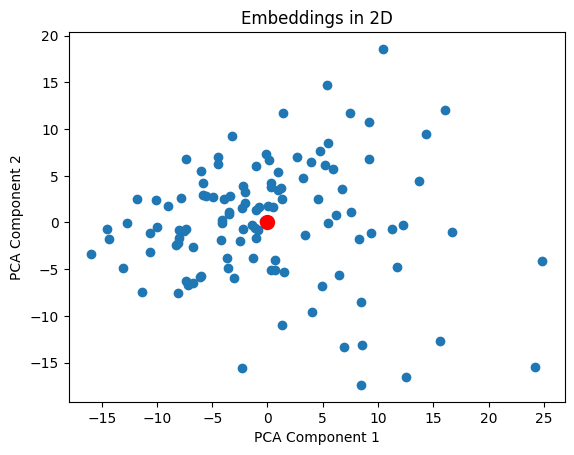

In [ ]:
# prompt: plot embeddings in two dimensions

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'embeddings' is your NumPy array of shape (n_samples, n_features)
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the embeddings in 2D
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Embeddings in 2D")
# Add a red dot for the mean embedding
plt.scatter(embeddings_2d[:, 0].mean(), embeddings_2d[:, 1].mean(), color='red', marker='o', s=100, label='Mean Embedding')
plt.show()


Dataset Processing


In [ ]:
# prompt: load music mp3 fild from /content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias and save the wav files in the folder BOTTOM Bias Wav

import os
from pydub import AudioSegment

input_folder = "/content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias"
output_folder = "/content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav"

if not os.path.exists(output_folder):
  os.makedirs(output_folder)

for filename in os.listdir(input_folder):
  if filename.endswith(".mp3"):
    input_path = os.path.join(input_folder, filename)
    output_path = os.path.join(output_folder, filename.replace(".mp3", ".wav"))
    sound = AudioSegment.from_mp3(input_path)
    sound.export(output_path, format="wav")
    print(f"Converted {filename} to {output_path}")


Converted Hello by Adele.mp3 to /content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav/Hello by Adele.wav
Converted Second Chance.mp3 to /content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav/Second Chance.wav
Converted Funkytown.mp3 to /content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav/Funkytown.wav
Converted Holiday.mp3 to /content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav/Holiday.wav
Converted _Sweet Caroline.mp3 to /content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav/_Sweet Caroline.wav
Converted Bang Bang.mp3 to /content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav/Bang Bang.wav
Converted La la la.mp3 to /content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav/La la la.wav
Converted Regulate.mp3 to /content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav/Regulate.wav
Converted Do You Remeber.mp3 to /content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav/Do You Remeber.wav
Conve

# Dataset Processing


In [ ]:
# prompt: for each wav file in /content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav, perform the following mus-musiccnn and save the dict of filename as key and predictions.mean(axis=0) as value

import os
from essentia.standard import MonoLoader, TensorflowPredictMusiCNN, TensorflowPredict2D

input_folder = "/content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav"
results = {}

filepath_1="/content/drive/MyDrive/Ai-Generated Music Storage/msd-musicnn-1.pb"
filepath_2="/content/drive/MyDrive/Ai-Generated Music Storage/deam-msd-musicnn-2.pb"

embedding_model = TensorflowPredictMusiCNN(graphFilename=filepath_1, output="model/dense/BiasAdd")
model = TensorflowPredict2D(graphFilename=filepath_2, output="model/Identity")

for filename in os.listdir(input_folder):
  if filename.endswith(".wav"):
    filepath = os.path.join(input_folder, filename)
    audio = MonoLoader(filename=filepath, sampleRate=16000, resampleQuality=4)()
    embeddings = embedding_model(audio)
    predictions = model(embeddings)
    results[filename] = predictions.mean(axis=0)

print(results)


{'Hello by Adele.wav': array([4.9266863, 4.8650165], dtype=float32), 'Second Chance.wav': array([5.425343, 5.948007], dtype=float32), 'Funkytown.wav': array([6.761478 , 6.5253882], dtype=float32), 'Holiday.wav': array([6.0128016, 6.422301 ], dtype=float32), '_Sweet Caroline.wav': array([4.7834263, 4.4769063], dtype=float32), 'Bang Bang.wav': array([5.268534 , 5.1840563], dtype=float32), 'La la la.wav': array([5.8483887, 5.908826 ], dtype=float32), 'Regulate.wav': array([5.557083, 5.348542], dtype=float32), 'Do You Remeber.wav': array([5.59272 , 5.329528], dtype=float32), 'The Rolling Stone.wav': array([6.5821333, 6.3023067], dtype=float32), 'promises,promises.wav': array([5.9039755, 6.4111586], dtype=float32), 'I Cry.wav': array([5.858644, 5.802855], dtype=float32), 'From a Distance.wav': array([5.091383, 5.216834], dtype=float32), 'Jean.wav': array([4.6708035, 4.532123 ], dtype=float32), 'Mississippi Queen.wav': array([5.207706 , 6.0083475], dtype=float32), 'Jump.wav': array([5.776086

In [ ]:
import os
from essentia.standard import TensorflowPredictEffnetDiscogs
input_folder = "/content/drive/MyDrive/Ai-Generated Music Storage/BOTTOM Bias Wav"
md1r = "/content/drive/MyDrive/Ai-Generated Music Storage/discogs-effnet-bs64-1.pb"
md2r = "/content/drive/MyDrive/Ai-Generated Music Storage/approachability_2c-discogs-effnet-1.pb"
md3r = "/content/drive/MyDrive/Ai-Generated Music Storage/approachability_regression-discogs-effnet-1.pb"
Approach_store = []
embedding_model = TensorflowPredictEffnetDiscogs(graphFilename=md1r, output="PartitionedCall:1")
model_classification = TensorflowPredict2D(graphFilename=md2r, output="model/Softmax")
model_regression = TensorflowPredict2D(graphFilename=md3r, output="model/Identity")
def classify_music(predictions):
  first_element_count = 0
  second_element_count = 0
  for prediction in predictions:
    if prediction[0] > 0.5:
      first_element_count += 1
    if prediction[1] > 0.5:
      second_element_count += 1
  if first_element_count > second_element_count:
    return 0
  else:
    return 1
for filename in os.listdir(input_folder):
   if filename.endswith(".wav"):  # Ensure only .wav files are processed
      filepath = os.path.join(input_folder, filename)

      audio = MonoLoader(filename=filepath, sampleRate=16000, resampleQuality=4)()

      embeddings = embedding_model(audio)

      predictions_classification = model_classification(embeddings)
      print(classify_music(predictions_classification))

      predictions_regression = model_regression(embeddings)
      Approach_store.append(predictions_regression.flatten().mean())

print(Approach_store)


1
[0.87064606]
1
[0.87064606, 0.7372783]
1
[0.87064606, 0.7372783, 0.8305228]
1
[0.87064606, 0.7372783, 0.8305228, 0.7944678]
1
[0.87064606, 0.7372783, 0.8305228, 0.7944678, 0.802678]
1
[0.87064606, 0.7372783, 0.8305228, 0.7944678, 0.802678, 0.9092788]
1
[0.87064606, 0.7372783, 0.8305228, 0.7944678, 0.802678, 0.9092788, 0.6896096]
1
[0.87064606, 0.7372783, 0.8305228, 0.7944678, 0.802678, 0.9092788, 0.6896096, 0.8471556]
1
[0.87064606, 0.7372783, 0.8305228, 0.7944678, 0.802678, 0.9092788, 0.6896096, 0.8471556, 0.90594316]
1
[0.87064606, 0.7372783, 0.8305228, 0.7944678, 0.802678, 0.9092788, 0.6896096, 0.8471556, 0.90594316, 0.8791763]
1
[0.87064606, 0.7372783, 0.8305228, 0.7944678, 0.802678, 0.9092788, 0.6896096, 0.8471556, 0.90594316, 0.8791763, 0.794442]
0
[0.87064606, 0.7372783, 0.8305228, 0.7944678, 0.802678, 0.9092788, 0.6896096, 0.8471556, 0.90594316, 0.8791763, 0.794442, 0.48387405]
1
[0.87064606, 0.7372783, 0.8305228, 0.7944678, 0.802678, 0.9092788, 0.6896096, 0.8471556, 0.905943

In [ ]:
eng_p1="/content/drive/MyDrive/Ai-Generated Music Storage/engagement_2c-discogs-effnet-1.pb"
eng_p2="/content/drive/MyDrive/Ai-Generated Music Storage/engagement_regression-discogs-effnet-1.pb"
Engage_store=[]
for filename in os.listdir(input_folder):
  filepath = os.path.join(input_folder,filename)
  audio = MonoLoader(filename=filepath, sampleRate=16000, resampleQuality=4)()
  embedding_model = TensorflowPredictEffnetDiscogs(graphFilename=md1r, output="PartitionedCall:1")
  embeddings = embedding_model(audio)

  model = TensorflowPredict2D(graphFilename=eng_p1, output="model/Softmax")
  predictions = model(embeddings)
  print(classify_music(predictions))

  model = TensorflowPredict2D(graphFilename=eng_p2, output="model/Identity")
  predictions = model(embeddings)
  Engage_store.append(predictions.flatten().mean())
print(Engage_store)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
[0.6250983, 0.8242527, 0.9527167, 0.9188991, 0.6933123, 0.5518765, 0.93649006, 0.7302139, 0.99837494, 0.95902604, 0.9466432, 0.9490812, 0.7368869, 0.65236443, 0.86395574, 0.9023881, 0.66000026, 0.6914998, 0.81888413, 0.726519, 0.9709975, 0.7442907, 0.9617843, 0.66365296, 0.7618211, 0.9245149, 0.69049317, 0.7652847, 0.67302173]


In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D
dance_p = "/content/drive/MyDrive/Ai-Generated Music Storage/danceability-discogs-effnet-1.pb"
dance_store=[]
for filename in os.listdir(input_folder):
  filepath = os.path.join(input_folder,filename)
  audio = MonoLoader(filename = filepath, sampleRate=16000, resampleQuality=4)()
  embedding_model = TensorflowPredictEffnetDiscogs(graphFilename=md1r, output="PartitionedCall:1")
  embeddings = embedding_model(audio)

  model = TensorflowPredict2D(graphFilename=dance_p, output="model/Softmax")
  predictions = model(embeddings)
  print(classify_music(predictions))
  dance_store.append(predictions)
print(dance_store)

流式输出内容被截断，只能显示最后 5000 行内容。
       [9.9686557e-01, 3.1344618e-03],
       [9.9761009e-01, 2.3899388e-03],
       [9.9830937e-01, 1.6906793e-03],
       [9.9832302e-01, 1.6769255e-03],
       [9.9522132e-01, 4.7787186e-03],
       [9.9824882e-01, 1.7511701e-03],
       [9.9973530e-01, 2.6463441e-04],
       [9.9962997e-01, 3.7005413e-04],
       [9.9966371e-01, 3.3625323e-04],
       [9.9942905e-01, 5.7088863e-04],
       [9.9983573e-01, 1.6426656e-04],
       [9.9985278e-01, 1.4723270e-04],
       [9.9950039e-01, 4.9958384e-04],
       [9.9556607e-01, 4.4339295e-03],
       [9.8086840e-01, 1.9131642e-02],
       [9.9863178e-01, 1.3682285e-03],
       [9.9859089e-01, 1.4091475e-03],
       [9.9808204e-01, 1.9180122e-03],
       [9.8927116e-01, 1.0728829e-02],
       [9.9701524e-01, 2.9848022e-03],
       [9.9847084e-01, 1.5291317e-03],
       [9.9859041e-01, 1.4095582e-03],
       [9.9749196e-01, 2.5080924e-03],
       [9.9644274e-01, 3.5572215e-03],
       [9.9766761e-01, 2.3323726e-03]

In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D
magg_p = "/content/drive/MyDrive/Ai-Generated Music Storage/mood_aggressive-discogs-effnet-1.pb"
for filename in os.listdir(input_folder):
  filepath = os.path.join(input_folder,filename)
  audio = MonoLoader(filename=filepath, sampleRate=16000, resampleQuality=4)()
  embedding_model = TensorflowPredictEffnetDiscogs(graphFilename=md1r, output="PartitionedCall:1")
  embeddings = embedding_model(audio)

  model = TensorflowPredict2D(graphFilename=magg_p, output="model/Softmax")
  predictions = model(embeddings)
  print(classify_music(predictions))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D
mhapp_p = "/content/drive/MyDrive/Ai-Generated Music Storage/mood_happy-discogs-effnet-1.pb"
for filename in os.listdir(input_folder):
  filepath = os.path.join(input_folder,filename)
  audio = MonoLoader(filename=filepath, sampleRate=16000, resampleQuality=4)()
  embedding_model = TensorflowPredictEffnetDiscogs(graphFilename="discogs-effnet-bs64-1.pb", output="PartitionedCall:1")
  embeddings = embedding_model(audio)

  model = TensorflowPredict2D(graphFilename = mhapp_p, output="model/Softmax")
  predictions = model(embeddings)
  print(classify_music(predictions))

In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D
import numpy as np
mtags_p = "/content/drive/MyDrive/Ai-Generated Music Storage/mtt-discogs-effnet-1.pb"
tag_list = ["ambient", "beat", "beats", "cello", "choir", "choral", "classic", "classical", "country", "dance", "drums", "electronic", "fast", "female", "female vocal", "female voice", "flute", "guitar", "harp", "harpsichord", "indian", "loud", "male", "male vocal", "male voice", "man", "metal", "new age", "no vocal", "no vocals", "no voice", "opera", "piano", "pop", "quiet", "rock", "singing", "sitar", "slow", "soft", "solo", "strings", "synth", "techno", "violin", "vocal", "vocals", "voice", "weird", "woman"]
def top_5_tags(predictions, tag_list):
  # Find the index of the tag with the highest value for each second
  top_indices = np.argmax(predictions, axis=1)

  # Count the occurrences of each tag
  tag_counts = {}
  for idx in top_indices:
    tag = tag_list[idx]
    if tag not in tag_counts:
      tag_counts[tag] = 0
    tag_counts[tag] += 1

  # Sort the tags by count in descending order and get the top 5
  top_5_tags = sorted(tag_counts, key=tag_counts.get, reverse=True)[:5]

  return top_5_tags, tag_counts
for filename in os.listdir(input_folder):
  filepath = os.path.join(input_folder,filename)
  audio = MonoLoader(filename=filepath, sampleRate=16000, resampleQuality=4)()
  embedding_model = TensorflowPredictEffnetDiscogs(graphFilename=md1r, output="PartitionedCall:1")
  embeddings = embedding_model(audio)

  model = TensorflowPredict2D(graphFilename=mtags_p)
  predictions = model(embeddings)
  t5_tags,_ = top_5_tags(predictions, tag_list)
  print(filename,":",t5_tags)


Hello by Adele.wav : ['female', 'piano', 'vocal', 'guitar', 'slow']
Second Chance.wav : ['rock', 'guitar', 'male', 'slow', 'man']
Funkytown.wav : ['techno', 'pop', 'vocal', 'slow', 'female']
Holiday.wav : ['female', 'techno', 'electronic', 'piano', 'classical']
_Sweet Caroline.wav : ['guitar', 'pop', 'rock', 'male vocal', 'country']
Bang Bang.wav : ['female', 'guitar', 'vocal', 'classical', 'pop']
La la la.wav : ['techno', 'female', 'beat', 'classical']
Regulate.wav : ['beat', 'vocal', 'female', 'pop', 'ambient']
Do You Remeber.wav : ['beat', 'pop', 'drums', 'techno', 'female']
The Rolling Stone.wav : ['drums', 'pop', 'techno', 'fast', 'rock']
promises,promises.wav : ['techno', 'female', 'slow', 'quiet']
I Cry.wav : ['techno', 'female', 'slow', 'electronic', 'piano']
From a Distance.wav : ['pop', 'guitar', 'female', 'rock', 'vocal']
Jean.wav : ['female', 'pop', 'guitar', 'vocal', 'slow']
Mississippi Queen.wav : ['rock', 'guitar', 'vocal', 'female', 'fast']
Jump.wav : ['beat', 'techno',

In [ ]:
from essentia.standard import MonoLoader, TensorflowPredictEffnetDiscogs, TensorflowPredict2D
mtg_p = "/content/drive/MyDrive/Ai-Generated Music Storage/mtg_jamendo_top50tags-discogs-effnet-1.pb"
for filename in os.listdir(input_folder):
  filepath = os.path.join(input_folder,filename)
  audio = MonoLoader(filename=filepath, sampleRate=16000, resampleQuality=4)()
  embedding_model = TensorflowPredictEffnetDiscogs(graphFilename=md1r, output="PartitionedCall:1")
  embeddings = embedding_model(audio)

  model = TensorflowPredict2D(graphFilename=mtg_p)
  predictions = model(embeddings)


  tag_list = ["alternative", "ambient", "atmospheric", "chillout", "classical", "dance", "downtempo", "easylistening", "electronic", "experimental", "folk",
  "funk", "hiphop", "house", "indie", "instrumentalpop", "jazz", "lounge", "metal", "newage", "orchestral", "pop", "popfolk", "poprock", "reggae", "rock",
  "soundtrack", "techno", "trance", "triphop", "world", "acousticguitar", "bass", "computer", "drummachine", "drums", "electricguitar",
  "electricpiano", "guitar", "keyboard", "piano", "strings", "synthesizer", "violin", "voice", "emotional", "energetic", "film", "happy", "relaxing"]

  top_5, tag_counts = top_5_tags(predictions, tag_list)

  print(filename, "Top 5 tags:", top_5)
  print("Tag counts:", tag_counts)

Hello by Adele.wav Top 5 tags: ['pop', 'piano', 'hiphop', 'classical', 'rock']
Tag counts: {'piano': 13, 'pop': 168, 'hiphop': 11, 'chillout': 1, 'classical': 5, 'rock': 2}
Second Chance.wav Top 5 tags: ['rock', 'ambient', 'soundtrack', 'electronic']
Tag counts: {'rock': 231, 'electronic': 1, 'ambient': 4, 'soundtrack': 2}
Funkytown.wav Top 5 tags: ['pop', 'electronic', 'hiphop', 'classical']
Tag counts: {'electronic': 109, 'pop': 116, 'hiphop': 4, 'classical': 1}
Holiday.wav Top 5 tags: ['pop', 'electronic', 'house', 'piano', 'dance']
Tag counts: {'pop': 139, 'electronic': 10, 'house': 1, 'piano': 1, 'dance': 1}
_Sweet Caroline.wav Top 5 tags: ['pop', 'rock', 'popfolk', 'classical', 'electronic']
Tag counts: {'pop': 98, 'popfolk': 7, 'rock': 58, 'classical': 1, 'electronic': 1}
Bang Bang.wav Top 5 tags: ['pop', 'folk', 'rock', 'popfolk', 'piano']
Tag counts: {'popfolk': 3, 'folk': 5, 'pop': 115, 'piano': 2, 'rock': 4, 'electronic': 2}
La la la.wav Top 5 tags: ['electronic', 'pop', 'sy

In [ ]:
from essentia.standard import MonoLoader, TempoCNN
tcnn_p="/content/drive/MyDrive/Ai-Generated Music Storage/deepsquare-k16-3.pb"
for filename in os.listdir(input_folder):
  filepath = os.path.join(input_folder,filename)
  audio = MonoLoader(filename=filepath, sampleRate=11025, resampleQuality=4)()
  model = TempoCNN(graphFilename=tcnn_p)
  global_tempo, local_tempo, local_tempo_probabilities = model(audio)# prompt: generate a new tag list from MTG-Jamendo Dataset
  print(global_tempo)

86.0
142.0
114.0
124.0
92.0
110.0
138.0
94.0
114.0
118.0
132.0
129.0
102.0
90.0
82.0
92.0
74.0
92.0
150.0
78.0
118.0
84.0
113.0
74.0
78.0
126.0
94.0
95.0
96.0
